# Предсказание оттока клиентов

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Для проекта по анализу оттока клиентов из банка необходимо сделать прогноз, уйдет ли клиент в ближайшем будущем или нет. Имеются исторические данные о поведении клиентов и расторжении договоров с банком.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

## Подготовка данных

Установим необходимые пакеты, если они отсутствуют

In [271]:
def check_if_installed(packages):
    for package in packages:
        try:
            exec(f'import {package}')
        except Exception as ex:
            print(ex)
            !pip install {package}
            # exec(f'import {package}')

libs = [
    'scikit-learn==1.1.3',
    'imblearn'
]

check_if_installed(libs)


invalid syntax (<string>, line 1)


In [302]:
import os

from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


Загрузим датасет и посмотрим на данные.

In [273]:
BASE_DIR = os.getcwd()

df = pd.read_csv(f'{BASE_DIR}/datasets/Churn_Modelling.csv')

In [274]:
df.head(5)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Признаки:**  
  
`RowNumber` - индекс строки  
`CustomerId` - уникальный идентификатор клиента  
`Surname` - фамилия  
`CreditScore` - кредитный рейтинг  
`Geography` - страна проживания  
`Gender` - пол  
`Age` - возраст  
`Tenure` - сколько лет человек является клиентом банка  
`Balance` - баланс на счете  
`NumOfProducts` - количество банковских продуктов, используемых клиентом  
`HasCrCard` - наличие кредитной карты  
`IsActiveMember` - активность клиента  
`EstimatedSalary` - зарплата  
  
**Целевой признак:**  
  
`Exited` - факт ухода клиента 



Изучим общие характеристики датасета

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Пропуски в данных отсутствуют. В столбцах RowNumber, Surname, CustomerId нет необходимости, они излишни для обучения модели, удалим их.

In [276]:
df = df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)


In [277]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


На первый взгляд в данных не видны аномалии.

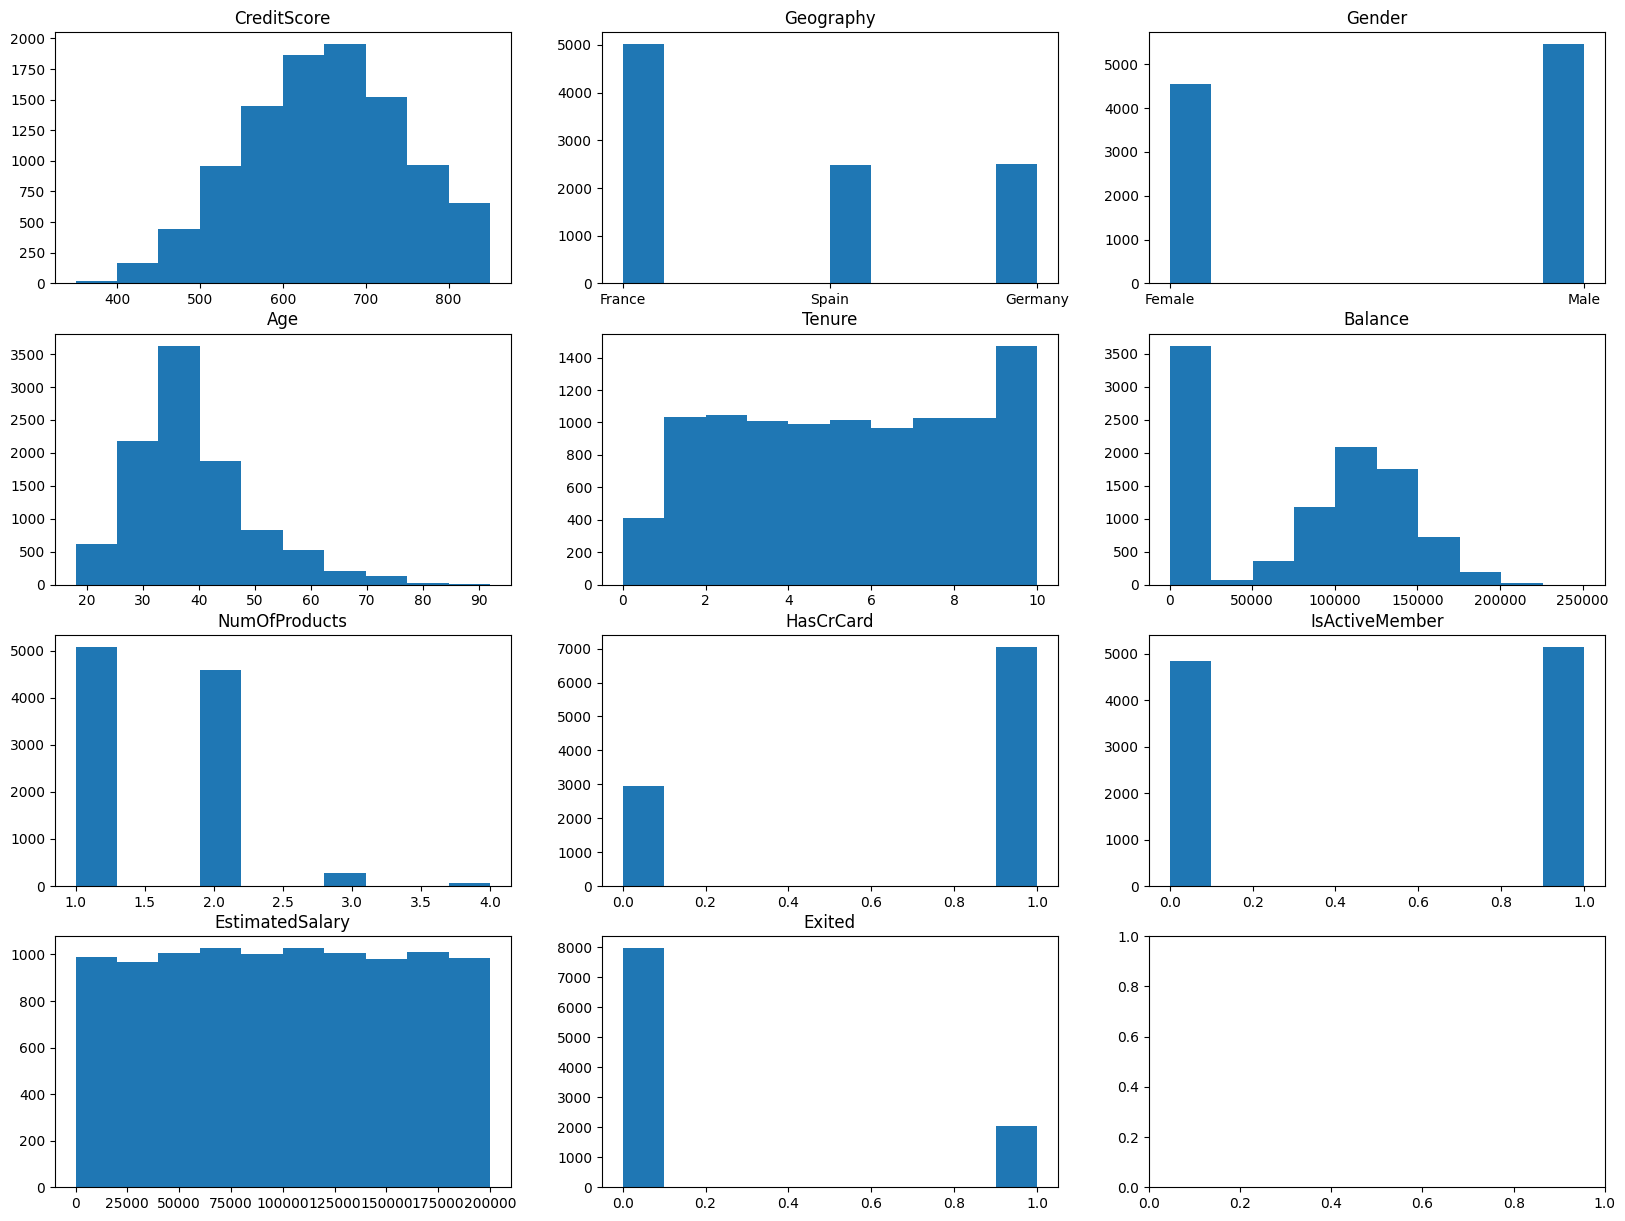

In [278]:
import math

fig, axs = plt.subplots(math.ceil(len(df.columns)/3), 3, figsize=(20, 15))
for i, col in enumerate(df.columns):
    axs[i//3][i%3].hist(df[col])
    axs[i//3][i%3].set_title(col)
plt.show()


На второй взгляд тоже.

Разделим выборку на обучающую, валидационную и тестовую в отношении 4:1:1

In [279]:
target = df['Exited']
feature = df.drop(['Exited'], axis=1)
feature_train_val, feature_test, target_train_val, target_test = train_test_split(
    feature, target, test_size=0.20, random_state=1)
feature_train, feature_valid, target_train, target_valid = train_test_split(
    feature_train_val, target_train_val, test_size=0.25, random_state=1)
feature_test_cat = feature_test.copy()
target_test_cat = target_test.copy()


Проверим корректность разбивки.

In [243]:
feature_train.shape, target_train.shape, feature_valid.shape, target_valid.shape, feature_test.shape, target_test.shape


((6000, 10), (6000,), (2000, 10), (2000,), (2000, 10), (2000,))

`Gender`, `Geography` - категориальные признаки, изучим их подробнее и выберем метод обработки.

In [244]:
feature_train['Gender'].value_counts()

Male      3281
Female    2719
Name: Gender, dtype: int64

In [245]:
feature_train['Geography'].value_counts()

France     2976
Germany    1520
Spain      1504
Name: Geography, dtype: int64

В признаках `Gender` и `Geography` две и три категории соответственно. Категорий не много ,значит мы можем применить метод `OneHotEncoding`

In [246]:
cats = ['Gender', 'Geography']

In [247]:
encoder_ohe = OneHotEncoder(
    drop='first', handle_unknown='ignore', sparse=False
)

encoder_ohe.fit(feature_train[cats])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [248]:
feature_train[encoder_ohe.get_feature_names_out()]\
      = encoder_ohe.transform(feature_train[cats])
feature_train = feature_train.drop(cats, axis=1)

In [249]:
feature_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
4495,789,32,7,69423.52,1,1,0,107499.39,0.0,0.0,0.0
6470,583,41,5,77647.60,1,1,0,190429.52,0.0,1.0,0.0
2221,767,35,6,132253.22,1,1,0,115566.57,0.0,1.0,0.0
7686,718,48,9,0.00,2,1,1,72105.63,1.0,0.0,0.0
9419,686,26,1,57422.62,1,1,1,79189.40,1.0,1.0,0.0


Тем же энекодером закодируем валидационную и тестовую выборки

In [250]:
feature_valid[encoder_ohe.get_feature_names_out()]\
    = encoder_ohe.transform(feature_valid[cats])
feature_valid = feature_valid.drop(cats, axis=1)

feature_test[encoder_ohe.get_feature_names_out()]\
    = encoder_ohe.transform(feature_test[cats])
feature_test = feature_test.drop(cats, axis=1)

Проверим результат

In [251]:
feature_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
7857,850,27,6,96654.72,2,0,0,152740.16,1.0,0.0,0.0
9924,632,50,5,107959.39,1,1,1,6985.34,0.0,1.0,0.0
3087,439,36,2,165536.28,2,1,1,123956.83,1.0,0.0,0.0
3513,790,33,10,135120.72,1,0,0,195204.99,0.0,0.0,0.0
2105,492,31,7,0.00,2,1,1,49463.44,0.0,0.0,0.0


In [252]:
feature_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
9953,550,47,2,0.00,2,1,1,97057.28,1.0,0.0,0.0
3850,680,34,3,143292.95,1,1,0,66526.01,1.0,0.0,0.0
4962,531,42,2,0.00,2,0,1,90537.47,0.0,0.0,0.0
3886,710,34,8,147833.30,2,0,1,1561.58,1.0,1.0,0.0
5437,543,30,6,73481.05,1,1,1,176692.65,1.0,1.0,0.0


Стандартизируем значения числовых признаков:  
`CreditScore`  
`Age`  
`Balance`  
`Tenure`  
`EstimatedSalary`  
`NumOfProducts`

In [253]:
scaler = StandardScaler()
nums = [
    'CreditScore', 
    'Age', 
    'Balance',
    'Tenure', 
    'EstimatedSalary', 
    'NumOfProducts'
]

feature_train[nums] = scaler.fit_transform(feature_train[nums])
feature_valid[nums] = scaler.fit_transform(feature_valid[nums])
feature_test[nums] = scaler.fit_transform(feature_test[nums])

In [254]:
feature_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
4495,1.427934,-0.656100,0.681651,-0.113714,-0.905397,1,0,0.134255,0.0,0.0,0.0
6470,-0.705851,0.198238,-0.014444,0.018224,-0.905397,1,0,1.572963,0.0,1.0,0.0
2221,1.200054,-0.371320,0.333604,0.894255,-0.905397,1,0,0.274208,0.0,1.0,0.0
7686,0.692503,0.862723,1.377746,-1.227467,0.805051,1,1,-0.479772,1.0,0.0,0.0
9419,0.361041,-1.225658,-1.406634,-0.306243,-0.905397,1,1,-0.356880,1.0,1.0,0.0


Там где возможно заменим типы данных на более лёгкие, используем метод downcast

In [255]:
feature_train = feature_train.apply(pd.to_numeric, downcast='integer')
feature_train = feature_train.apply(pd.to_numeric, downcast='float')

feature_valid = feature_valid.apply(pd.to_numeric, downcast='integer')
feature_valid = feature_valid.apply(pd.to_numeric, downcast='float')

feature_test = feature_test.apply(pd.to_numeric, downcast='integer')
feature_test = feature_test.apply(pd.to_numeric, downcast='float')

feature_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 4495 to 7029
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        6000 non-null   float32
 1   Age                6000 non-null   float32
 2   Tenure             6000 non-null   float32
 3   Balance            6000 non-null   float32
 4   NumOfProducts      6000 non-null   float32
 5   HasCrCard          6000 non-null   int8   
 6   IsActiveMember     6000 non-null   int8   
 7   EstimatedSalary    6000 non-null   float32
 8   Gender_Male        6000 non-null   int8   
 9   Geography_Germany  6000 non-null   int8   
 10  Geography_Spain    6000 non-null   int8   
dtypes: float32(6), int8(5)
memory usage: 216.8 KB




**В результате подготовки данных:**
   - были удалены признаки с излишней информацией; 
   - данные разделены на выборки;  
   - к категориальным признакам примененён метод OHE;
   - количественные признакми стандартизированы;
   - типы данных заменены на более лёгкие.

Изучим баланс классов

In [256]:
weights = target_train.value_counts(normalize=True)
print(weights)


0    0.798833
1    0.201167
Name: Exited, dtype: float64


Классы целевого признака не сбалансированы, необходимо это исправить.  
Прежде чем бороться с дисбалансом найдём лучшие параметры модели на несбалансированной выборке, будем их использовать в качестве ориентира при оценке качества балансировки классов.  
Основная цель задачи предсказать отток клиентов, наиболее важная метрика для нас recall, оптимизируем по AUC-ROC.

## Обучение моделей

### Функция для оптимизации параметров классических моделей

In [257]:
def optimizer(X_t, y_t, X_v, y_v, max_depth, n_estimators, random_state, balance=None):
    """
    Функция обучает логистическую регрессию, решающее дерево, случайный лес и выводит их f1 и auc_roc.

    Аргументы:
    X_t - признаки обучающей выборки;
    y_t - целевой признак обучающей выборки;
    X_v - признаки валидационной выборки;
    y_v - целевой признак валидационной выборки;
    max_depth - максимальная глубина дерева (для DecisionTreeClassifier и RandomForestClassifier);
    n_estimators - количество деревьев (для RandomForestClassifier);
    random_state - параметр для воспроизводимости результатов;
    balance - параметр для балансировки классов (по умолчанию None).

    Результаты:
    best_model_rf - лучшая модель с максимальной метрикой f1.
    """
    best_f1_dt, best_auc_roc_dt, best_model_dt = 0, 0, None
    best_f1_rf, best_auc_roc_rf, best_model_rf = 0, 0, None

    model_cb = CatBoostClassifier(verbose=0, random_state=random_state)
    model_cb.fit(X_t, y_t)
    y_p = model_cb.predict(X_v)
    f1_cb = f1_score(y_v, y_p)
    auc_roc_cb = roc_auc_score(target_valid, model_cb.predict_proba(X_v)[:, 1])

    model_lr = LogisticRegression(
        random_state=random_state, solver='liblinear', class_weight=balance)
    model_lr.fit(X_t, y_t)
    y_p = model_lr.predict(X_v)
    f1_lr = f1_score(y_v, y_p)
    auc_roc_lr = roc_auc_score(target_valid, model_lr.predict_proba(X_v)[:, 1])

    for depth in range(1, max_depth, 1):
        model_dt = DecisionTreeClassifier(
            random_state=random_state, max_depth=depth, class_weight=balance)
        model_dt.fit(X_t, y_t)
        y_p = model_dt.predict(X_v)
        f1_dt = f1_score(y_v, y_p)
        if f1_dt > best_f1_dt:
            auc_roc_dt = roc_auc_score(
                target_valid, model_dt.predict_proba(X_v)[:, 1])
            best_f1_dt, best_model_dt, best_auc_roc_dt = f1_dt, model_dt, auc_roc_dt

        for n_est in range(1, n_estimators, 1):
            model_rf = RandomForestClassifier(
                random_state=random_state, n_estimators=n_est, max_depth=depth, class_weight=balance)
            model_rf.fit(X_t, y_t)
            y_p = model_rf.predict(X_v)
            f1_rf = f1_score(y_v, y_p)
            if f1_rf > best_f1_rf:
                auc_roc_rf = roc_auc_score(
                    target_valid, model_rf.predict_proba(X_v)[:, 1])
                best_f1_rf, best_model_rf, best_auc_roc_rf = f1_rf, model_rf, auc_roc_rf


    results = {
        'model_cb': {
            'best_f1': f1_cb,
            'best_auc_roc': auc_roc_cb,
            'model' : model_cb
        },
        'model_lr': {
            'best_f1': f1_lr,
            'best_auc_roc': auc_roc_lr,
            'model' : model_lr
        },
        'model_dt': {
            'best_f1': best_f1_dt,
            'best_auc_roc': best_auc_roc_dt,
            'model' : model_dt
        },
        'model_rf': {
            'best_f1': best_f1_rf,
            'best_auc_roc': best_auc_roc_rf,
            'model' : model_rf
        }
    }

    print(pd.DataFrame.from_dict(results, orient='index'))

    best_model = max(results, key=lambda x: results[x]['best_auc_roc'])

    return results[best_model]['model']



In [258]:
optimizer(feature_train, target_train, feature_valid, target_valid, 30, 50, 1)


c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


           best_f1  best_auc_roc  \
model_cb  0.549849      0.846332   
model_lr  0.301075      0.763872   
model_dt  0.514200      0.798354   
model_rf  0.559398      0.821798   

                                                      model  
model_cb  <catboost.core.CatBoostClassifier object at 0x...  
model_lr  LogisticRegression(random_state=1, solver='lib...  
model_dt  DecisionTreeClassifier(max_depth=29, random_st...  
model_rf  (DecisionTreeClassifier(max_depth=29, max_feat...  


Лучший показатель у модели CatBoostClassifier, худший у LogisticRegression  

## Борьба с дисбалансом

### Балансирование взвешиванием классов

In [259]:
model_weighted = optimizer(feature_train, target_train,
                           feature_valid, target_valid, 30, 50, 1, 'balanced')


c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


           best_f1  best_auc_roc  \
model_cb  0.549849      0.846332   
model_lr  0.496991      0.763609   
model_dt  0.570297      0.778068   
model_rf  0.621908      0.839515   

                                                      model  
model_cb  <catboost.core.CatBoostClassifier object at 0x...  
model_lr  LogisticRegression(class_weight='balanced', ra...  
model_dt  DecisionTreeClassifier(class_weight='balanced'...  
model_rf  (DecisionTreeClassifier(max_depth=29, max_feat...  


Лучший результат у CatBoostClassifier, причём он не отличается от результата без взвешивания, попробуем также другие варианты балансировки.

### Балансирование методом downsample

Сбалансируем выборку.

In [260]:
rus = RandomUnderSampler(random_state=1)
feature_train_down, target_train_down = rus.fit_resample(
    feature_train, target_train)


In [261]:
print(target_train_down.value_counts(normalize=True))


0    0.5
1    0.5
Name: Exited, dtype: float64


Обучим модель на выборке

In [262]:
model_down = optimizer(feature_train_down, target_train_down,
                       feature_valid, target_valid, 30, 50, 1, 'balanced')


c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


           best_f1  best_auc_roc  \
model_cb  0.577143      0.843515   
model_lr  0.497427      0.762480   
model_dt  0.563536      0.815538   
model_rf  0.590420      0.831662   

                                                      model  
model_cb  <catboost.core.CatBoostClassifier object at 0x...  
model_lr  LogisticRegression(class_weight='balanced', ra...  
model_dt  DecisionTreeClassifier(class_weight='balanced'...  
model_rf  (DecisionTreeClassifier(max_depth=29, max_feat...  


Метод балансировки downsample показал результат не лучше, чем взвешивание классов. Случайный лес также в лидерах и по f1 и по auc_roc

### Балансирование методом upsample

Сбалансируем выборку

In [263]:
oversample = SMOTE(random_state=1)
feature_train_up, target_train_up = oversample.fit_resample(
    feature_train, target_train)


Проверим баланс классов

In [264]:
print(target_train_up.value_counts(normalize=True))


0    0.5
1    0.5
Name: Exited, dtype: float64


Обучим модель на выборке

In [265]:
model_up = optimizer(feature_train_up, target_train_up,
                     feature_valid, target_valid, 30, 50, 1, 'balanced')


c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


           best_f1  best_auc_roc  \
model_cb  0.382044      0.800383   
model_lr  0.491166      0.757367   
model_dt  0.512397      0.743856   
model_rf  0.573913      0.796825   

                                                      model  
model_cb  <catboost.core.CatBoostClassifier object at 0x...  
model_lr  LogisticRegression(class_weight='balanced', ra...  
model_dt  DecisionTreeClassifier(class_weight='balanced'...  
model_rf  (DecisionTreeClassifier(max_depth=29, max_feat...  


Метод балансировки upsample также не показал результат лучше, чем взвешивание классов.

In [266]:
model_weighted

**В результате подбора метода балансировки и оптимизации гиперпараметров можно сделать следующие выводы:**
- независимо от того сбалансирована ли выборка и независимо от метода балансировки, лучшей из рассмотренных моделей является `CatBoostClassifier`;
- модель лучше обучилась на несбалансированной выборке;

Результат на валидационной выборке:  
    f1 = 0.55  
    AUC-ROC = 0.85  

Оптимизируем гиперпараметры базовой модели с помощью GridSearchCV. Для кросс-валидации будем использовать выборку до разделения на обучающую и валидационную. Также мы можем пропустить шаг стандартизации числовых признаков и OHE, т.к. это не обязательно для CatBoost

In [267]:
model_cb = CatBoostClassifier(verbose=0, random_state=1, cat_features=cats)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 4, 5, 6, 7, 8],
    'l2_leaf_reg': [1, 2, 3, 4, 5, 6, 7, 8],
    'iterations': [50, 100, 200],
}

grid_search = GridSearchCV(
    model_cb, 
    param_grid, 
    cv=4, 
    n_jobs=-1, 
    scoring='roc_auc'
)

grid_search.fit(feature_train_val, target_train_val)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


Best parameters:  {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 2, 'learning_rate': 0.05}
Best score:  0.869327653065124


Максимальный `AUC-ROC=0.87` достигнут при  
`max_depth` = 4  
`l2_leaf_reg` = 2  
`learning_rate` = 0.05  
`iterations` = 200  

## Тестирование модели

Протестируем лучшую из полученных моделей на тестовой выборке. 

In [288]:
model = grid_search.best_estimator_
target_predicted = model.predict(feature_test_cat)
roc_auc = roc_auc_score(target_test, target_predicted)
print(f"ROC-AUC на тестовой выборке = {roc_auc}")


ROC-AUC на тестовой выборке = 0.7263958040363346


c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


Модель показала удовлетворительный результат на тестовой выборке. Тест пройден.

Лучшая модель для решения задачи пронозирования ухода клиента - `CatBoostClassifier` с параметрами:
  `max_depth` = 4  
  `l2_leaf_reg` = 2  
  `learning_rate` = 0.05  
  `iterations` = 200  

Подберём порог для классификации и посмотрим какой recall мы можем получить.  
Взглянем на ROC-кривую.

c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


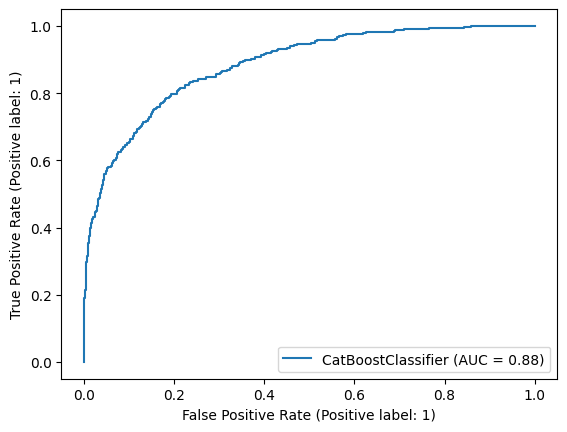

In [305]:
plot_roc_curve(model, feature_test, target_test)
plt.show()

Подберём оптимальное пороговое значение

In [306]:
target_predicted_probabilities = model.predict_proba(feature_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, target_predicted_probabilities)

# Находим индекс точки на графике, ближайшей к верхнему левому углу
index = np.argmax(np.abs(tpr - fpr))
# Определяем пороговое значение, соответствующее этой точке
threshold = thresholds[index]

print("Оптимальное пороговое значение:", threshold)

Оптимальное пороговое значение: 0.19067794856748335


c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


Оценим recall при оптимальном пороговом значении

In [301]:
target_predicted = model.predict_proba(feature_test)[:, 1] > threshold
recall = recall_score(target_test, target_predicted, pos_label=1)
print(f"Recall на тестовой выборке = {recall:.2f}")

Recall на тестовой выборке = 0.80


c:\Users\danii\anaconda3\envs\practicum\lib\site-packages\catboost\core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


**В процессе работы были проделаны следующие шаги:**
  - исходная выборка была подготовлена к работе;
  - модель была протестирована на несбалансированных данных;
  - модель была обучена на выборках сбаллансированных различными способами;
  - в ходе работы была использована функция подбирающая модели и гиперпараметры моделей;
  - лучшая модель была апробирована на тестовой выборке;
  - подобран threshold для максимизации recall.

Полученная модель будет успешно определять клиента банка прежде, чем он откажется от услуг в 80% случаев.